In [2]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from utils import * 
import xarray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

2022-10-31 14:35:47.687451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
cwd = os.getcwd()
train_path = "data/train/"
test_path = "data/test/"

# Training set
train_files    = ["mantua"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('water', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('water',data_path=test_path,time_reindex=False)

In [5]:
X_train_df = X_train_xr["ssrd"].stack(dim=["latitude", "longitude"])
X_test_df = X_test_xr["ssrd"].stack(dim=["latitude", "longitude"])



y_train_df = y_train_xr["planeOfArrayIrradiance"].stack(dim=["latitude", "longitude"]).fillna(0)
y_train_df = pd.DataFrame(y_train_df.to_pandas())
y_test_df = y_test_xr["planeOfArrayIrradiance"].stack(dim=["latitude", "longitude"]).fillna(0)


In [93]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
Y_test = y_test_df.to_numpy()

print(X_train.shape,y_train.shape)
print(X_test.shape,y_train.shape)


(11198, 6) (11198, 1)
(11198, 4) (11198, 1)


In [96]:
# set hyperparameters
n_neuron       = 512
activation     = 'relu'
num_epochs     = 48
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

#create the model
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               3584      
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 529,409
Trainable params: 529,409
Non-trainable params: 0
_________________________________________________________________


In [97]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.5, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/48
88/88 [==============================] - 1s 6ms/step - loss: 84937.8281 - val_loss: 72220.5703
Epoch 2/48
88/88 [==============================] - 0s 5ms/step - loss: 74275.5938 - val_loss: 69684.1484
Epoch 3/48
88/88 [==============================] - 0s 5ms/step - loss: 73282.4609 - val_loss: 68403.9844
Epoch 4/48
88/88 [==============================] - 0s 5ms/step - loss: 72819.0000 - val_loss: 68170.0625
Epoch 5/48
88/88 [==============================] - 0s 5ms/step - loss: 72307.0000 - val_loss: 68394.6172
Epoch 6/48
88/88 [==============================] - 0s 5ms/step - loss: 72684.2578 - val_loss: 68274.8281
Epoch 7/48
88/88 [==============================] - 0s 5ms/step - loss: 72426.0703 - val_loss: 68081.3047
Epoch 8/48
88/88 [==============================] - 0s 5ms/step - loss: 72739.8125 - val_loss: 67817.7109
Epoch 9/48
88/88 [==============================] - 0s 5ms/step - loss: 72289.2812 - val_loss: 68155.8906
Epoch 10/48
88/88 [===========================

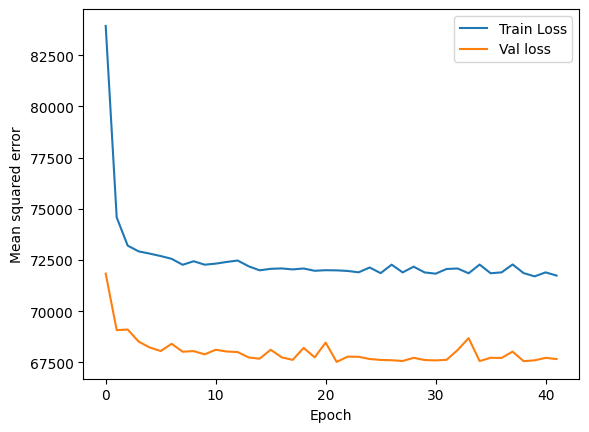

In [43]:
plot_history(history)

In [44]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [45]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.h5'))

In [46]:
# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.h5'))

In [47]:
coords_mantua = {'lon' : 39.766038926962466, 'lat' : -75.14202657295235}
coords_west = {'lon' : 41.13935584322975, 'lat' : -73.52551929903115}
coords_water = {'lon' : 39.75493159954764, 'lat' : -74.88289845779185}

In [50]:
X_test

array([[-0.57123077, -0.5711687 , -0.57272017, -0.5726581 ],
       [-0.55937725, -0.55931526, -0.5613632 , -0.5613012 ],
       [-0.5560262 , -0.5560262 , -0.5583224 , -0.5583224 ],
       ...,
       [-0.6075358 , -0.6075358 , -0.6075358 , -0.6075358 ],
       [-0.6075358 , -0.6075358 , -0.6075358 , -0.6075358 ],
       [-0.6075358 , -0.6075358 , -0.6075358 , -0.6075358 ]],
      dtype=float32)

In [49]:
y_test_pre = model.predict(X_test)

ValueError: in user code:

    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 6), found shape=(None, 4)


In [ ]:
df_test = pd.DataFrame(y_test_xr["directIrradiance"].stack(dim=["latitude", "longitude"]),columns=["y_actual"],index=X_test_xr["time"])
df_test["y_predict"] = y_test_pre
df_test

In [27]:
df_test[50:100]

NameError: name 'df_test' is not defined